In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import os, sys
from tqdm import tqdm
import pandas as pd 

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize


from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers import Input, Dense
from keras.layers.core import Dropout, Activation
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.models import Model

import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator


from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as preprocess_input_Xception

Using TensorFlow backend.


# Deep Learning 

On utilise maintenant des réseaux de neurones convolutif et plus spécialement des réseaux de neurones déjà entrainés sur un large corpus d'images pour identifier les différentes races de chiens. 
Plutôt que d'entrainer les étages inferieurs, étant donné que nous avons peu d'images (par rapport au corpus d'entrainement), nous choisissons de de rajouter deux niveaux suplémentaires (en utilisant un pooling(max) pour réduire la dimension) la dernier niveau est relié au vecteur de classe (dim=120) grace à une fonction softmax renvoyant donc la probabilité pour une image test de faire partie d'une classe donnée. 

Nous testons 3 architectures différentes en considérant 4 modèles. 
- vgg19 prenant en entrée des images de taille (224/224/3) 
- resnet50 prenant en entrée des images de même tailles
- une concatenation de vgg19 et resnet50 
- Xception prenant en entrée des images de taille (299/299/3)

Le fonctionnement de chacun de ces modèles est détaillé dans la présentation. Comme dans le notebook de segmentation classique, l'évaluation est faite en tenant compte de l'accuracy. Une évaluation détaillée en visualisant les erreurs, en regardant les races plus propices aux faux positifs et en visualisant les accuracies par race est réalisée. 

les hyperaramètres (dropout / taille des mini-batchs / nombre d'épochs) sont déterminés sur le jeu de validation préalablement stratifié en visualisant la fonction de cout de validation (qui doit être minimale), et les modèles finaux sont testés sur le jeu de test (stratifié lui aussi). 



In [2]:
def plot_value_counts(col_name,df):       
    
    values_count = pd.DataFrame(df[col_name].dropna().value_counts())
    #print (values_count.shape)
    values_count.columns = ['count']
    # convert the index column into a regular column.
    values_count[col_name] = [ str(i) for i in values_count.index ]
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = values_count['count'].div(values_count['count'].sum()).multiply(100).round(2)
    # change the order of the columns.
    values_count = values_count.reindex([col_name,'count','percent'],axis=1)
    values_count.reset_index(drop=True,inplace=True)
    return (values_count)

In [3]:
# compter et ouvrir les fichiers 

# Open a file
path = "./Images"
dirs = os.listdir( path )

liste_name = []
liste_number = [] 

# This would print all the files and directories
for file in dirs:
    
    liste_name.append(str(file))
    path2 = "./Images/" + str(file)
    dirs2 = os.listdir( path2 )
    
    n = 0
    for pictures in dirs2:
        n = n + 1 
    liste_number.append(n)

In [4]:
# ouvrir les fichiers 

# Open a file
path = "./Images"
dirs = os.listdir( path )

# list picture name 
picture = []
# list breed 
breed = []

# This would print all the files and directories
j = 0

#i = 0

for file in (dirs):
    
    #if (i > 4):
            
          #  break  # otherwise the generator would loop indefinitely
    
                
    #i = i + 1
    
    
    path2 = "./Images/" + str(file)
    dirs2 = os.listdir( path2 )
    
       
    # compter les itérations
    i_t = 0  
    
        
    for file2 in dirs2:       
               
              
        train_n = int(np.around( 0.60 * len(dirs2)/2))
        valid_n = int(np.around(0.80 * len(dirs2)/2))        
        
        breed.append(str(file))
        picture.append(str(file2))
        
        
        i_t = i_t + 1
        
        file_picture = path2 + '/' + str(file2)        
        
        
        if (i_t <= train_n):            
                    
            img = load_img(file_picture)  # this is a PIL image  
            
            img.save("./images_t/tr/"  + str(file2) ) 
                    
        if (i_t > train_n) and (i_t <= valid_n):
            
            img = load_img(file_picture)  # this is a PIL image
            
            img.save("./images_t/te/"  + str(file2) ) 
            
        if (i_t > valid_n):
            
            img = load_img(file_picture)  # this is a PIL image
            
            img.save("./images_t/valid/"  + str(file2) )
            
        if i_t > (np.around(len(dirs2)/2)):
            
                break  # otherwise the generator would loop indefinitely
                

                
d = {'picture_name': picture[:], 'breed': breed[:]}
labels = pd.DataFrame(data=d)

labels.to_csv('labels.csv')



In [4]:
# Open a file
path = "./images_t/tr/"
dirs = os.listdir( path )

nb_train = len(dirs)

# Open a file
path = "./images_t/te/"
dirs = os.listdir( path )

nb_test = len(dirs)

# Open a file
path = "./images_t/valid/"
dirs = os.listdir( path )

nb_valid = len(dirs)
    
print (nb_train, nb_test, nb_valid)

14855 5777 5827


In [6]:
valeurs = plot_value_counts('breed',df=labels)

liste_name = valeurs.iloc[:,0]

In [7]:
print (liste_name.shape)

(120,)


In [5]:
# PARAMS 

# nombre de classes (races de chiens)
nb_classes = 120
dim_Xception = 299
dim_vgg19 = 224


# ouvrir le fichier 

labels = pd.read_csv('labels.csv')

In [11]:
X_train = np.zeros((nb_train,dim_vgg19,dim_vgg19,3),dtype=np.float32)

y_train = np.zeros((nb_train,nb_classes),dtype='uint32')

In [12]:
X_test = np.zeros((nb_test,dim_vgg19,dim_vgg19,3),dtype=np.float32)

y_test = np.zeros((nb_test,nb_classes),dtype='uint32')

In [13]:
X_valid = np.zeros((nb_valid,dim_vgg19,dim_vgg19,3),dtype=np.float32)

y_valid = np.zeros((nb_valid,nb_classes),dtype='uint32')

In [14]:
j_te = 0

# Open a file
path = "./images_t/te/"
dirs = os.listdir( path )

for file in (dirs):
    #index = file.find('g')    
    
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_test[j_te,:] = label_binarize([class_name], classes=liste_name)
    #print (y_train[j_train,:])
        
    file_picture =  "./images_t/te/" + str(file)
    
    img = Image.open(file_picture)
    img.thumbnail((224, 224))
        
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
    X_test[j_te,0:matrix.shape[0],0:matrix.shape[1],:] = matrix[:,:,:]
        
    j_te = j_te + 1

In [15]:
j_valid = 0

# Open a file
path = "./images_t/valid/"
dirs = os.listdir( path )

for file in (dirs):
    #index = file.find('g')     
        
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_valid[j_valid,:] = label_binarize([class_name], classes=liste_name)
    #print (y_valid[j_valid,:])
        
    file_picture = "./images_t/valid/" + str(file)
     
    img = Image.open(file_picture)
    img.thumbnail((224, 224))
    
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
    X_valid[j_valid,0:matrix.shape[0],0:matrix.shape[1],:] = matrix[:,:,:]
        
    j_valid = j_valid + 1

In [16]:
j_train = 0

# Open a file
path = "./images_t/tr/"
dirs = os.listdir( path )

for file in (dirs):
    #index = file.find('g') 
    
        
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_train[j_train,:] = label_binarize([class_name], classes=liste_name)
    #print (y_train[j_train,:])
        
    file_picture =  "./images_t/tr/" + str(file)
    
    img = Image.open(file_picture)
    img.thumbnail((224, 224))
        
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
    X_train[j_train,0:matrix.shape[0],0:matrix.shape[1],:] = matrix[:,:,:]
        
    j_train = j_train + 1

In [17]:
imput_train_vgg19 = preprocess_input_vgg19(X_train.copy())
train_vgg19 = VGG19(weights='imagenet', include_top=False).predict(imput_train_vgg19, batch_size=32)

print ('done')

imput_test_vgg19 = preprocess_input_vgg19(X_test.copy())
test_vgg19 = VGG19(weights='imagenet', include_top=False).predict(imput_test_vgg19, batch_size=32)

print ('done')

imput_valid_vgg19 = preprocess_input_vgg19(X_valid.copy())
valid_vgg19 = VGG19(weights='imagenet', include_top=False).predict(imput_valid_vgg19, batch_size=32)

done
done


In [18]:
imput_train_resnet50 = preprocess_input_resnet50(X_train)
train_resnet50 = ResNet50(weights='imagenet', include_top=False).predict(imput_train_resnet50, batch_size=32)

print ('done')

imput_test_resnet50 = preprocess_input_resnet50(X_test.copy())
test_resnet50 = ResNet50(weights='imagenet', include_top=False).predict(imput_test_resnet50, batch_size=32)

print ('done')

imput_valid_resnet50 = preprocess_input_resnet50(X_valid)
valid_resnet50 = ResNet50(weights='imagenet', include_top=False).predict(imput_valid_resnet50, batch_size=32)

/usr/local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


done
done


# try vgg19 weight 

In [17]:
def input_branch(input_shape=None):
    
    size = int(input_shape[2] / 4)
    
    branch_input = Input(shape=input_shape)
    branch = GlobalAveragePooling2D()(branch_input)
    branch = Dense(size, use_bias=False, kernel_initializer='uniform')(branch)
    branch = BatchNormalization()(branch)
    branch = Activation("relu")(branch)
    return branch, branch_input

vgg19_branch, vgg19_input = input_branch(input_shape=(7, 7, 512))

net = Dropout(0.1)(vgg19_branch)
net = Dense(220, use_bias=False, kernel_initializer='uniform')(net)
net = BatchNormalization()(net)
net = Activation("relu")(net)
net = Dropout(0.1)(net)
net = Dense(120, kernel_initializer='uniform', activation="softmax")(net)

model = Model(inputs=[vgg19_input], outputs=[net])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 7, 7, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65536     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_295 (Activation)  (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 220)               28160     
__________

In [18]:
# checkpoints

early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_br1eed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "./models/{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=True)

In [19]:
model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])

model.fit([train_vgg19],y_train,
          validation_data=([valid_vgg19], y_valid),
          epochs=15, batch_size=4,callbacks=[model_checkpoint,early_stopping], verbose=2)

Train on 14855 samples, validate on 5827 samples
Epoch 1/15
 - 40s - loss: 2.6989 - acc: 0.3316 - val_loss: 1.3643 - val_acc: 0.6219
Epoch 2/15
 - 33s - loss: 2.1335 - acc: 0.4450 - val_loss: 1.2035 - val_acc: 0.6515
Epoch 3/15
 - 33s - loss: 2.0144 - acc: 0.4799 - val_loss: 1.1798 - val_acc: 0.6660
Epoch 4/15
 - 33s - loss: 1.9151 - acc: 0.4977 - val_loss: 1.1539 - val_acc: 0.6878
Epoch 5/15
 - 32s - loss: 1.8860 - acc: 0.5138 - val_loss: 1.1082 - val_acc: 0.6961
Epoch 6/15
 - 32s - loss: 1.8246 - acc: 0.5227 - val_loss: 1.0794 - val_acc: 0.6964
Epoch 7/15
 - 32s - loss: 1.8064 - acc: 0.5299 - val_loss: 1.0644 - val_acc: 0.7033
Epoch 8/15
 - 32s - loss: 1.7964 - acc: 0.5340 - val_loss: 1.0545 - val_acc: 0.7033
Epoch 9/15
 - 32s - loss: 1.7554 - acc: 0.5409 - val_loss: 1.0557 - val_acc: 0.7081
Epoch 10/15
 - 33s - loss: 1.7625 - acc: 0.5409 - val_loss: 1.0374 - val_acc: 0.7088
Epoch 11/15
 - 33s - loss: 1.7446 - acc: 0.5455 - val_loss: 1.0326 - val_acc: 0.7101
Epoch 12/15
 - 33s - loss

In [20]:
predictions = model.predict([test_vgg19])
breed_predictions = [np.argmax(prediction) for prediction in predictions]
breed_true_labels = [np.argmax(true_label) for true_label in y_test]
print('Test accuracy: %.4f%%' % (accuracy_score(breed_true_labels, breed_predictions) * 100))

Test accuracy: 70.2614%


In [21]:

list_predict = []
list_test = []

for i in range (len(breed_predictions)):
    list_predict.append(np.argmax(predictions[i]))
    list_test.append(np.argmax(y_test[i,:]))
    

d = {'predict': list_predict, 'test': list_test}
df = pd.DataFrame(data=d)

valeurs = plot_value_counts('test',df=df)
print (valeurs.shape)
print (nb_classes)

valeurs['test'] = valeurs['test'].astype('float64')

valeurs = valeurs.sort_values(by=['test'])



heat_matrix = np.zeros((nb_classes,nb_classes))


for i in range (valeurs.shape[0]):
    for j in range (valeurs.shape[0]):
        
        heat_matrix[i,j] = df[(df.iloc[:,0] == float(valeurs.iloc[i,0])) & (df.iloc[:,1] == float(valeurs.iloc[j,0]))].shape[0] / float(valeurs.iloc[j,1])
        
        
    
    

(120, 3)
120


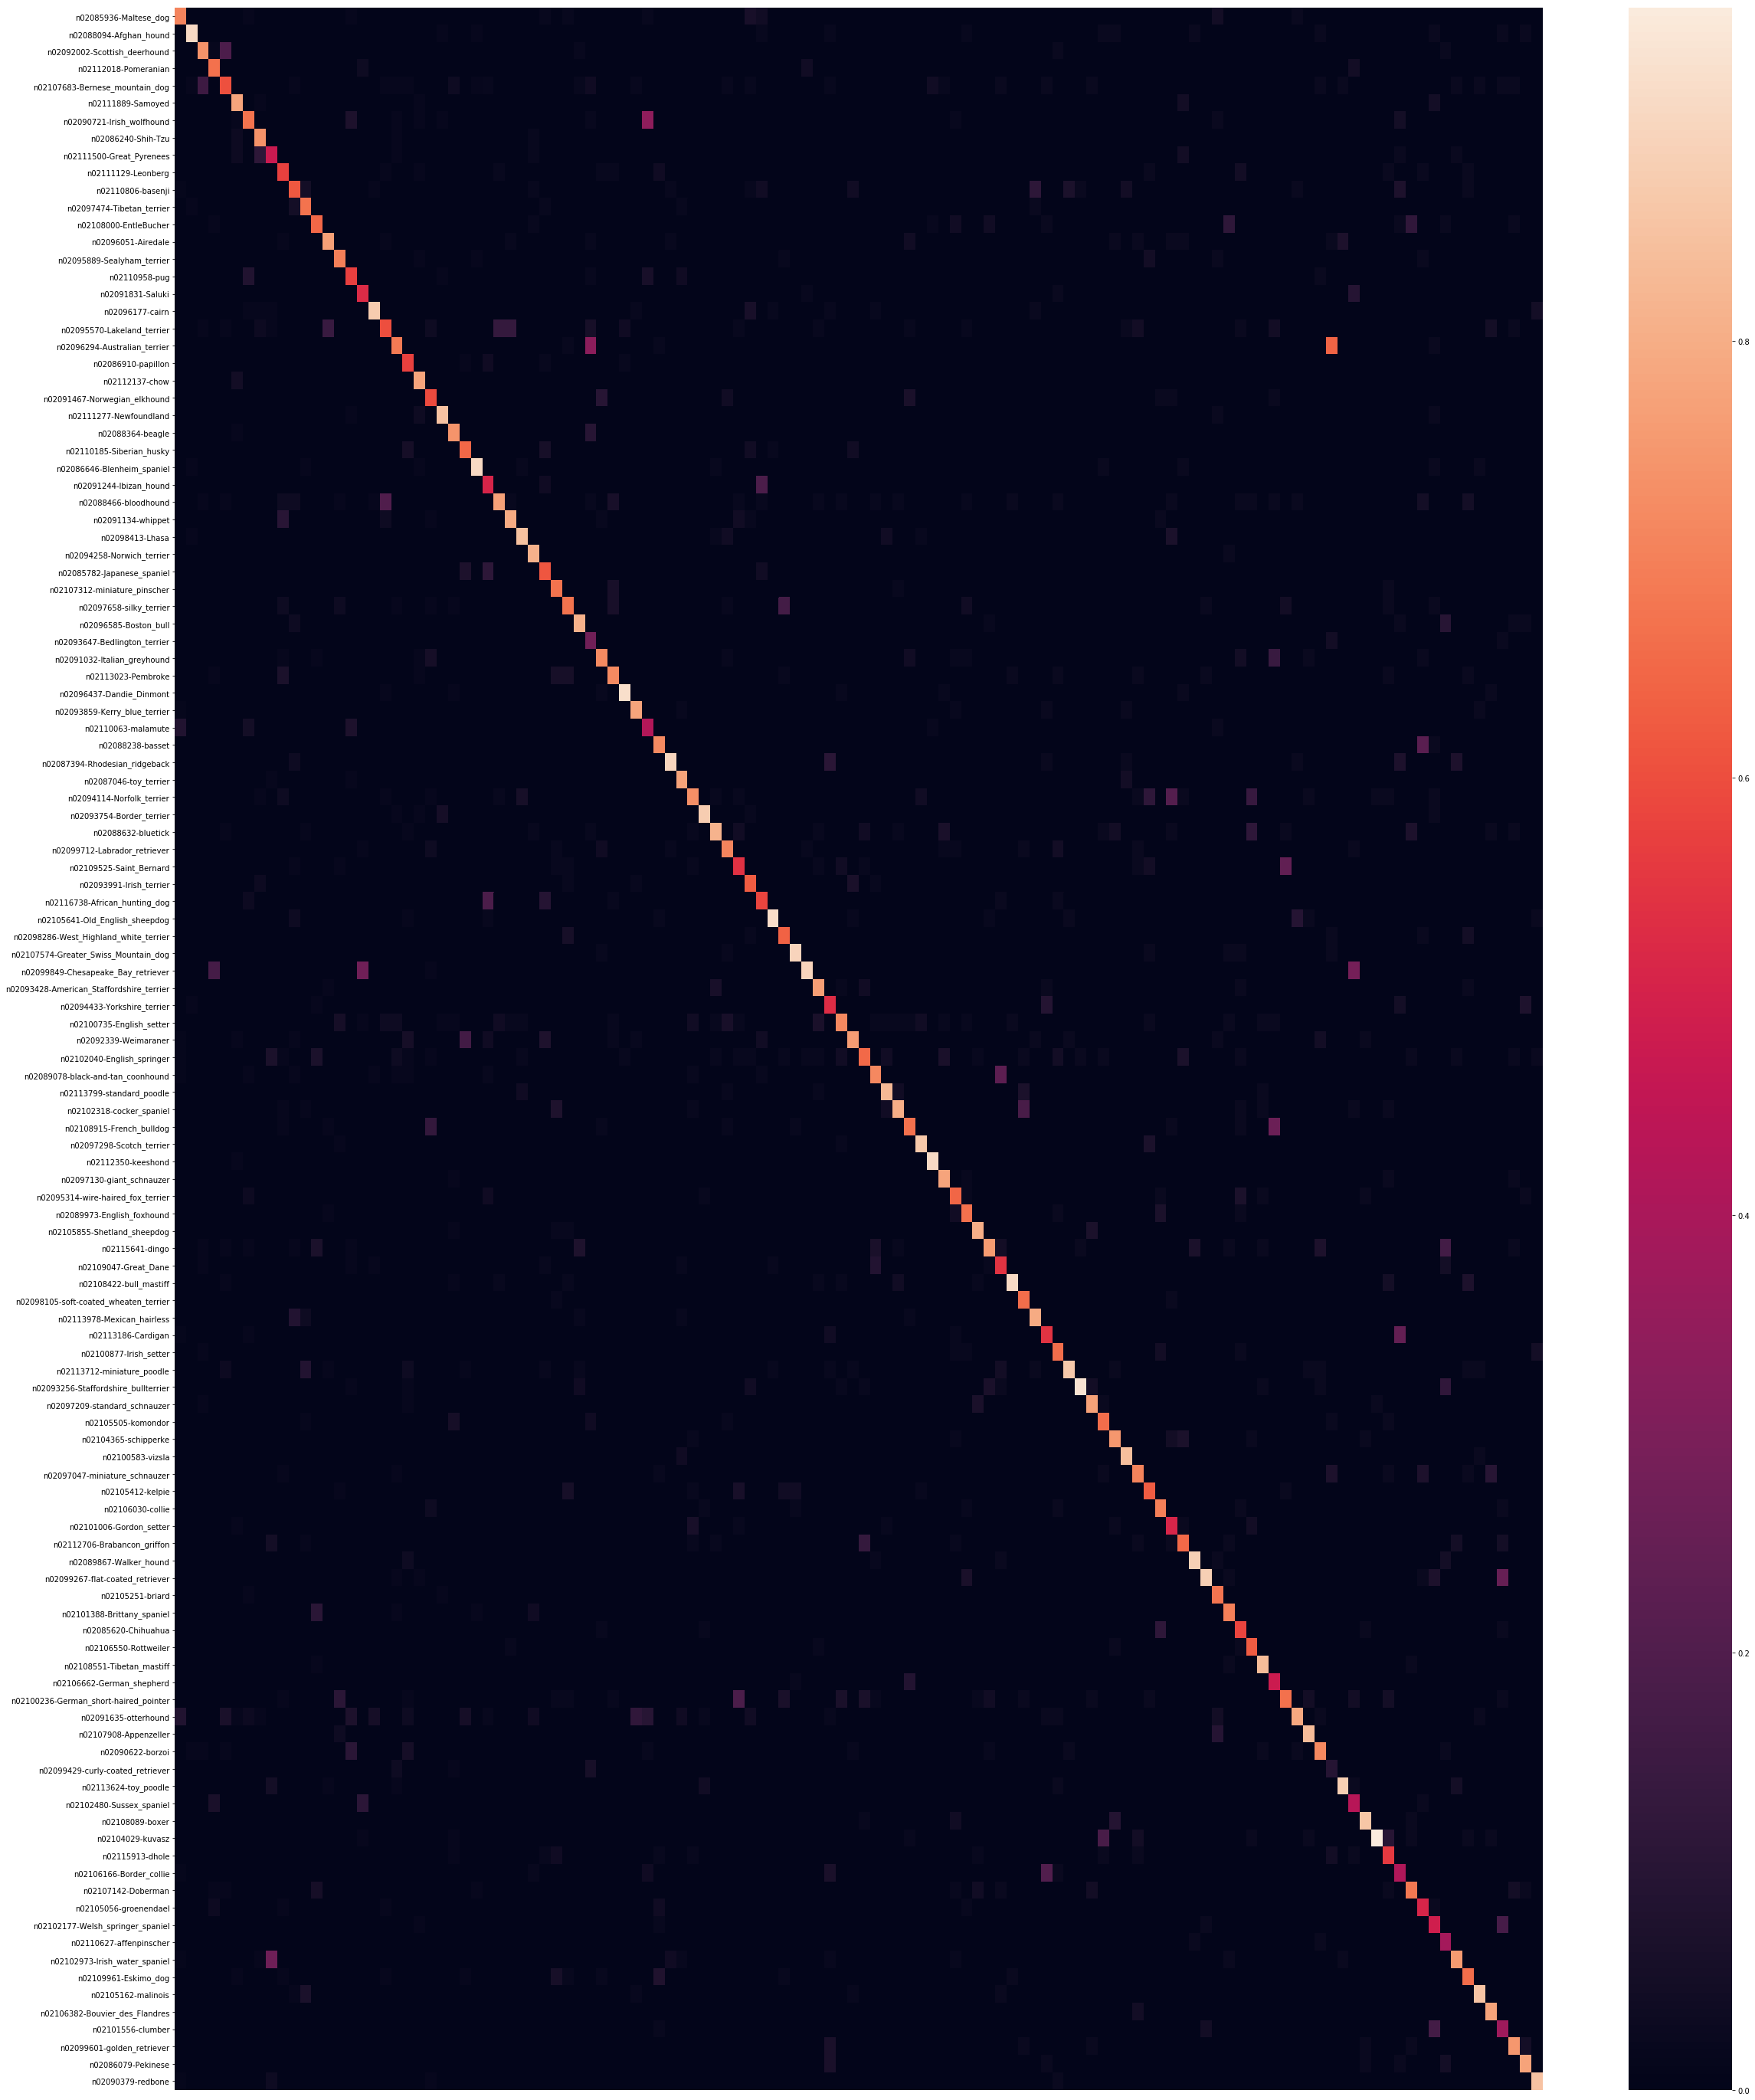

In [22]:
plt.figure(figsize=(40,50))

ax = sns.heatmap(heat_matrix,yticklabels=liste_name)

ax.axes.get_xaxis().set_visible(False)

plt.savefig('heatmap_1.png')

# try resnet55 weight

In [23]:
def input_branch(input_shape=None):
    
    size = int(input_shape[2] / 4)
    
    branch_input = Input(shape=input_shape)
    branch = GlobalAveragePooling2D()(branch_input)
    branch = Dense(size, use_bias=False, kernel_initializer='uniform')(branch)
    branch = BatchNormalization()(branch)
    branch = Activation("relu")(branch)
    return branch, branch_input

resnet50_branch, resnet50_input = input_branch(input_shape=(7, 7, 2048))

net = Dropout(0.2)(resnet50_branch)
net = Dense(500, use_bias=False, kernel_initializer='uniform')(net)
net = BatchNormalization()(net)
net = Activation("relu")(net)
net = Dropout(0.2)(net)
net = Dense(120, kernel_initializer='uniform', activation="softmax")(net)

model = Model(inputs=[resnet50_input], outputs=[net])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 7, 7, 2048)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
activation_297 (Activation)  (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 500)               256000    
__________

In [24]:
# checkpoints

early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "./models/{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=True)

In [25]:
model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])

model.fit([train_resnet50],y_train,
          validation_data=([valid_resnet50], y_valid),
          epochs=11, batch_size=5,callbacks=[model_checkpoint], verbose=2)

Train on 14855 samples, validate on 5827 samples
Epoch 1/11
 - 39s - loss: 1.8955 - acc: 0.4983 - val_loss: 0.8576 - val_acc: 0.7409
Epoch 2/11
 - 31s - loss: 1.3657 - acc: 0.6267 - val_loss: 0.7387 - val_acc: 0.7791
Epoch 3/11
 - 31s - loss: 1.2289 - acc: 0.6666 - val_loss: 0.6944 - val_acc: 0.7889
Epoch 4/11
 - 31s - loss: 1.1142 - acc: 0.6903 - val_loss: 0.6753 - val_acc: 0.8020
Epoch 5/11
 - 31s - loss: 1.0743 - acc: 0.7056 - val_loss: 0.6371 - val_acc: 0.8068
Epoch 6/11
 - 31s - loss: 1.0105 - acc: 0.7186 - val_loss: 0.6190 - val_acc: 0.8145
Epoch 7/11
 - 31s - loss: 0.9649 - acc: 0.7268 - val_loss: 0.6177 - val_acc: 0.8112
Epoch 8/11
 - 31s - loss: 0.9119 - acc: 0.7408 - val_loss: 0.5980 - val_acc: 0.8238
Epoch 9/11
 - 31s - loss: 0.8960 - acc: 0.7487 - val_loss: 0.5843 - val_acc: 0.8318
Epoch 10/11
 - 31s - loss: 0.8602 - acc: 0.7598 - val_loss: 0.5763 - val_acc: 0.8344
Epoch 11/11
 - 31s - loss: 0.8386 - acc: 0.7646 - val_loss: 0.5710 - val_acc: 0.8368


In [26]:
predictions = model.predict([test_resnet50])
breed_predictions = [np.argmax(prediction) for prediction in predictions]
breed_true_labels = [np.argmax(true_label) for true_label in y_test]
print('Test accuracy: %.4f%%' % (accuracy_score(breed_true_labels, breed_predictions) * 100))

Test accuracy: 83.5728%


In [27]:

list_predict = []
list_test = []

for i in range (len(breed_predictions)):
    list_predict.append(np.argmax(predictions[i]))
    list_test.append(np.argmax(y_test[i,:]))
    

d = {'predict': list_predict, 'test': list_test}
df = pd.DataFrame(data=d)

valeurs = plot_value_counts('test',df=df)
print (valeurs.shape)
print (nb_classes)

valeurs['test'] = valeurs['test'].astype('float64')

valeurs = valeurs.sort_values(by=['test'])


heat_matrix = np.zeros((nb_classes,nb_classes))


for i in range (valeurs.shape[0]):
    for j in range (valeurs.shape[0]):
        
        heat_matrix[i,j] = df[(df.iloc[:,0] == float(valeurs.iloc[i,0])) & (df.iloc[:,1] == float(valeurs.iloc[j,0]))].shape[0] / float(valeurs.iloc[j,1])
        
          

(120, 3)
120


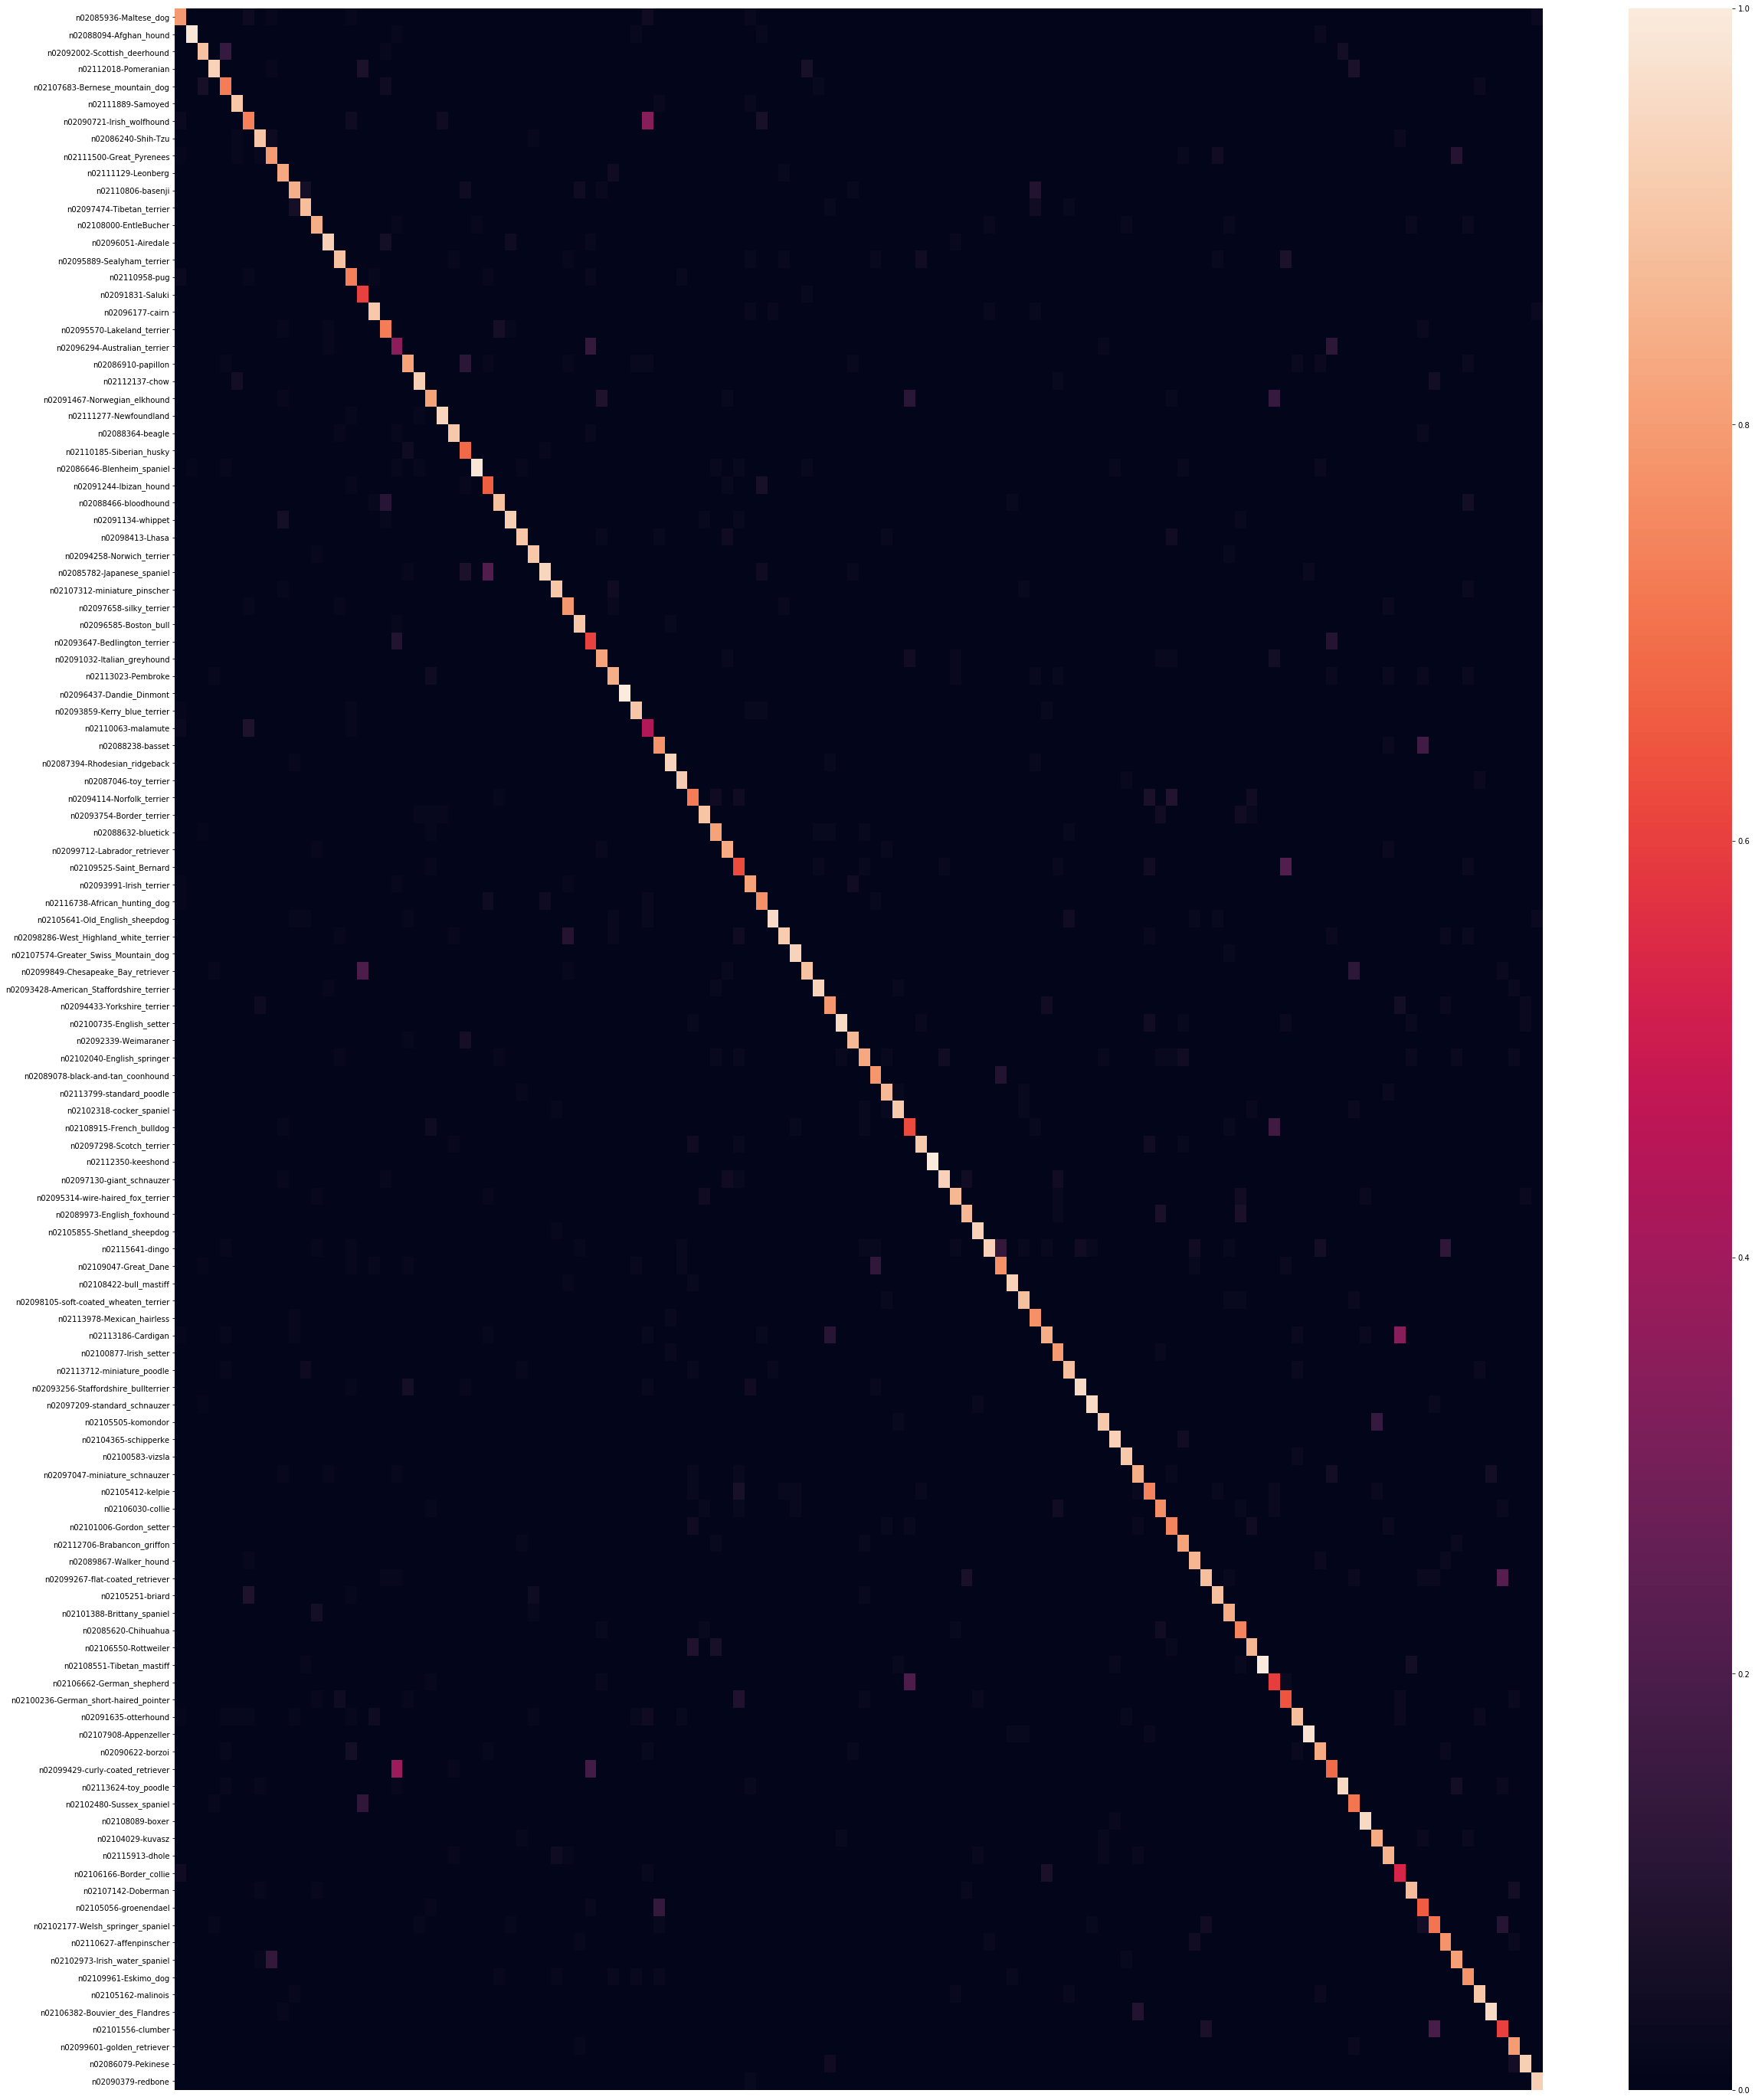

In [28]:
plt.figure(figsize=(40,50))

ax = sns.heatmap(heat_matrix,yticklabels=liste_name)

ax.axes.get_xaxis().set_visible(False)

plt.savefig('heatmap_2.png')

#  Try both

In [19]:
def input_branch(input_shape=None):
    
    size = int(input_shape[2] / 2)
    
    branch_input = Input(shape=input_shape)
    branch = GlobalAveragePooling2D()(branch_input)
    branch = Dense(size, use_bias=False, kernel_initializer='uniform')(branch)
    branch = BatchNormalization()(branch)
    branch = Activation("relu")(branch)
    return branch, branch_input

vgg19_branch, vgg19_input = input_branch(input_shape=(7, 7, 512))
resnet50_branch, resnet50_input = input_branch(input_shape=(7, 7, 2048))
concatenate_branches = Concatenate()([vgg19_branch, resnet50_branch])
net = Dropout(0.35)(concatenate_branches)
net = Dense(640, use_bias=False, kernel_initializer='uniform')(net)
net = BatchNormalization()(net)
net = Activation("relu")(net)
net = Dropout(0.35)(net)
net = Dense(120, kernel_initializer='uniform', activation="softmax")(net)

model = Model(inputs=[vgg19_input, resnet50_input], outputs=[net])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 7, 7, 2048)   0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           input_7[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 2048)         0           input_8[0][0]                    
__________________________________________________________________________________________________
dense_1 (D

In [20]:
# checkpoints

early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_br2eed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "./models/{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=True)

In [21]:
model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])


model.fit([train_vgg19, train_resnet50], y_train, 
          validation_data=([valid_vgg19, valid_resnet50], y_valid),
          epochs=13, batch_size=5, callbacks=[model_checkpoint], verbose=2)

Train on 14855 samples, validate on 5827 samples
Epoch 1/13
 - 39s - loss: 1.9776 - acc: 0.4811 - val_loss: 0.8508 - val_acc: 0.7288
Epoch 2/13
 - 35s - loss: 1.4532 - acc: 0.6145 - val_loss: 0.7506 - val_acc: 0.7687
Epoch 3/13
 - 36s - loss: 1.3059 - acc: 0.6527 - val_loss: 0.7186 - val_acc: 0.7805
Epoch 4/13
 - 36s - loss: 1.1944 - acc: 0.6751 - val_loss: 0.6562 - val_acc: 0.8054
Epoch 5/13
 - 36s - loss: 1.1518 - acc: 0.6870 - val_loss: 0.6287 - val_acc: 0.8116
Epoch 6/13
 - 36s - loss: 1.1020 - acc: 0.7043 - val_loss: 0.6191 - val_acc: 0.8117
Epoch 7/13
 - 36s - loss: 1.0306 - acc: 0.7223 - val_loss: 0.5922 - val_acc: 0.8274
Epoch 8/13
 - 35s - loss: 1.0099 - acc: 0.7262 - val_loss: 0.5869 - val_acc: 0.8238
Epoch 9/13
 - 35s - loss: 0.9793 - acc: 0.7363 - val_loss: 0.5632 - val_acc: 0.8342
Epoch 10/13
 - 36s - loss: 0.9409 - acc: 0.7393 - val_loss: 0.5639 - val_acc: 0.8368
Epoch 11/13
 - 36s - loss: 0.9309 - acc: 0.7415 - val_loss: 0.5508 - val_acc: 0.8383
Epoch 12/13
 - 36s - loss

In [33]:
predictions = model.predict([test_vgg19, test_resnet50])
#print (predictions[0:5,:])
breed_predictions = [np.argmax(prediction) for prediction in predictions]
breed_true_labels = [np.argmax(true_label) for true_label in y_test]
print('Test accuracy: %.4f%%' % (accuracy_score(breed_true_labels, breed_predictions) * 100))

Test accuracy: 83.7459%


In [34]:

list_predict = []
list_test = []

for i in range (len(breed_predictions)):
    list_predict.append(np.argmax(predictions[i]))
    list_test.append(np.argmax(y_test[i,:]))
    

d = {'predict': list_predict, 'test': list_test}
df = pd.DataFrame(data=d)

valeurs = plot_value_counts('test',df=df)
print (valeurs.shape)
print (nb_classes)

valeurs['test'] = valeurs['test'].astype('float64')

valeurs = valeurs.sort_values(by=['test'])



heat_matrix = np.zeros((nb_classes,nb_classes))


for i in range (valeurs.shape[0]):
    for j in range (valeurs.shape[0]):
        
        heat_matrix[i,j] = df[(df.iloc[:,0] == float(valeurs.iloc[i,0])) & (df.iloc[:,1] == float(valeurs.iloc[j,0]))].shape[0] / float(valeurs.iloc[j,1])
       
        
    

(120, 3)
120


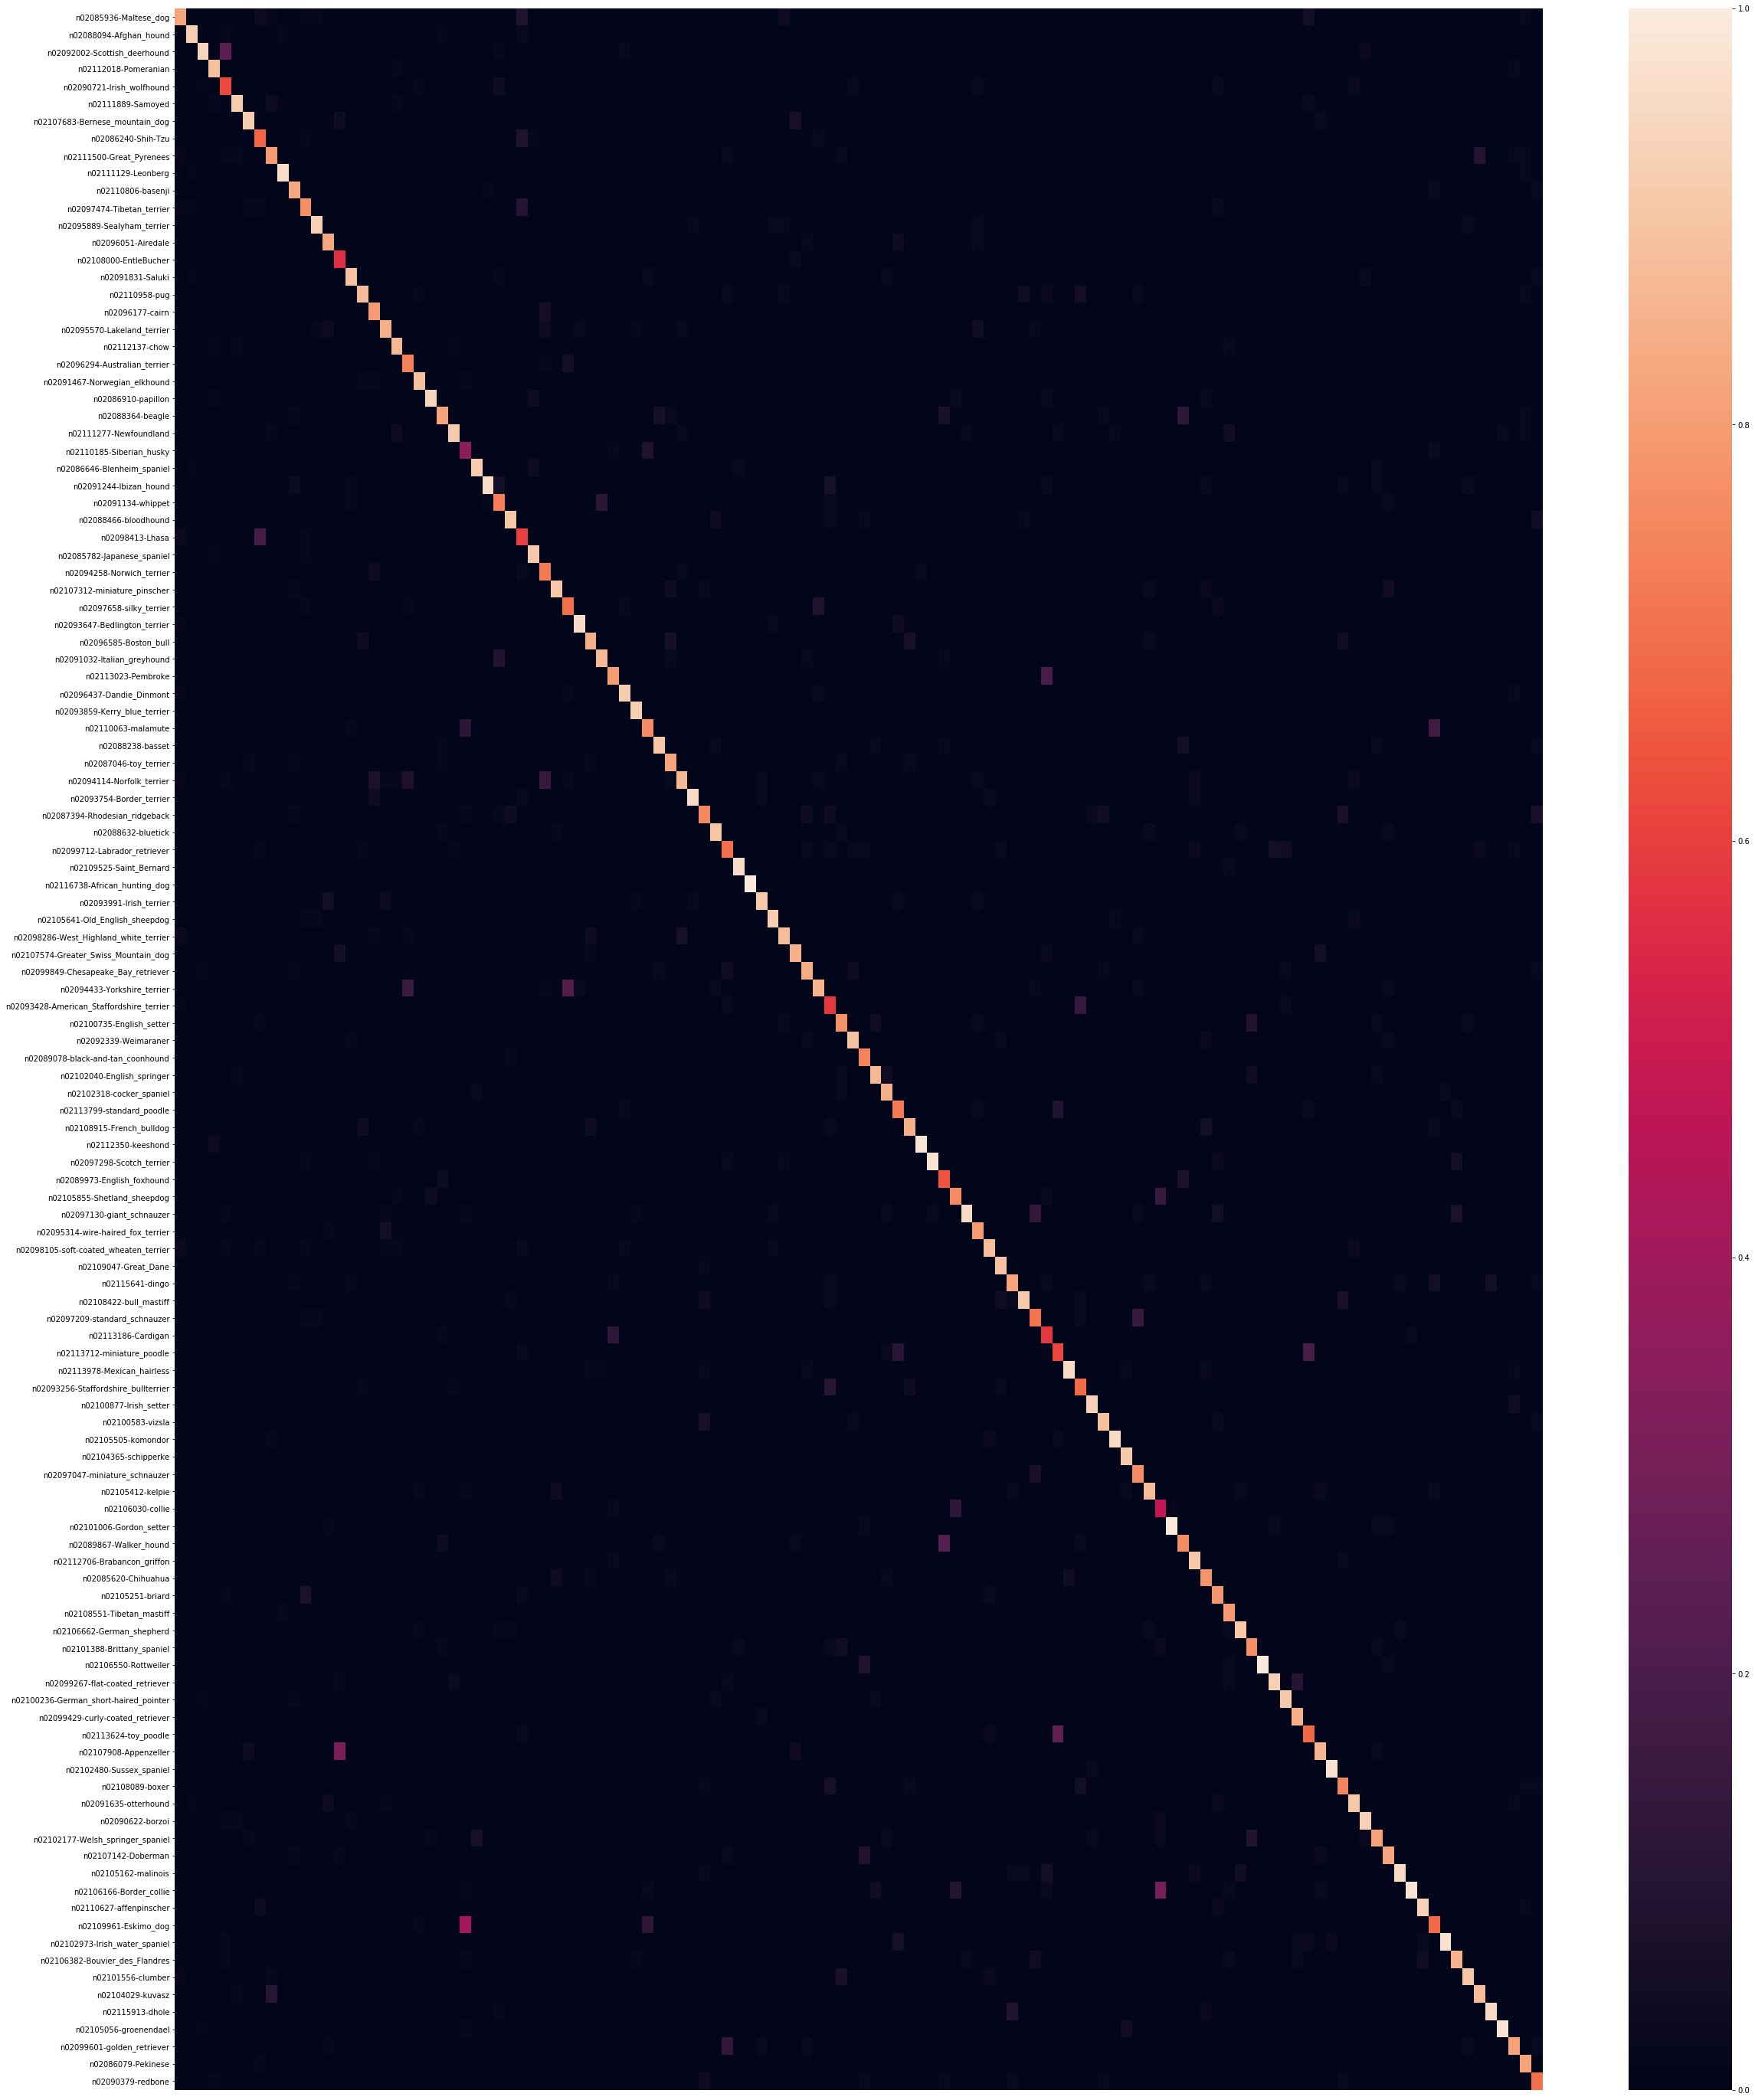

In [35]:
plt.figure(figsize=(40,50))

ax = sns.heatmap(heat_matrix,yticklabels=liste_name)

ax.axes.get_xaxis().set_visible(False)

plt.savefig('heatmap_3.png')

In [43]:
np.save('heatmap_mixed1.npy', heat_matrix)
np.save('liste_name.npy', np.asarray(liste_name))

In [36]:
def visualiser(df,nb_exemples):
    #""" visualiser les échecs """"
    
    # mixed data do not print every time the same pictures    
    df = shuffle(df)

    # i breack
    i_b = 0

    # nombre d'exemples que l'on cherche à visualiser

    fig = plt.figure(1, figsize=(16, 16))

    grid = ImageGrid(fig, 111, nrows_ncols=(nb_exemples, 2), axes_pad=0.1)

    
    for i in range (df.shape[0]):
        if (df.iloc[i,0] != df.iloc[i,1]):         
                
            ax = grid[i_b]

            indice = int(df.iloc[2*i,0])

            ax.imshow(X_test[2*i,:,:,:] / 255.)
            ax.text(20, 100, 'PREDICTED: {}'.format(liste_name[indice]), color='white', backgroundcolor='b', alpha=1)

            ax.axis('off')
                
            i_b = i_b + 1
                
                
            ax = grid[i_b]    

            indice = int(df.iloc[2*i+1,0])

            ax.imshow(X_test[2*i+1,:,:,:] / 255.)
            ax.text(20, 100, 'REAL: {}'.format(liste_name[indice]), color='white', backgroundcolor='r', alpha=1)

            ax.axis('off')       


            i_b = i_b + 1
            
            if i_b > nb_exemples + 2:
            
                break  # otherwise the generator would loop indefinitely

    ax.axis('off')            
    plt.show()      
        

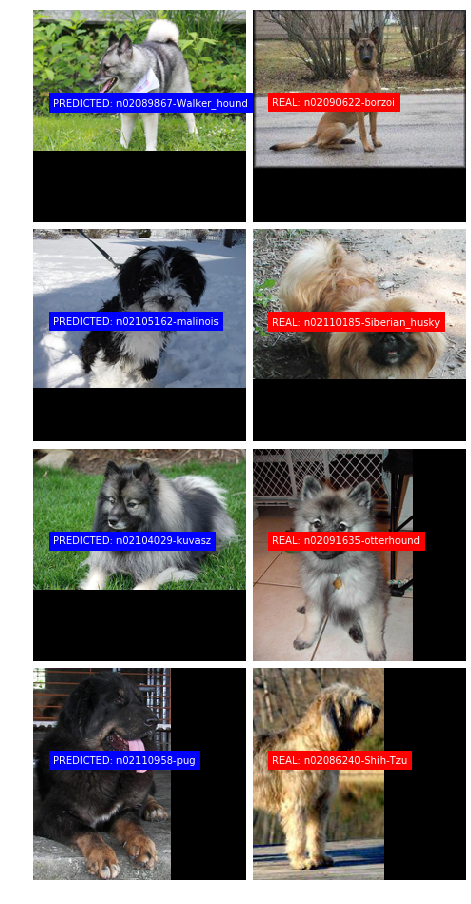

In [37]:
# visualier 4 exemples incorrects (relancer la fonction visualisera 4 nouveaux exemples)
visualiser(df=df,nb_exemples=4)

In [38]:
def performance_best(liste_name,heatmap,nb):
    """retourne la liste des nb meilleures performances (race/race) ainsi que la liste des accuracies"""
    perf_name = []
    perf_element = []    
    
    for i in range (heatmap.shape[0]):
        
        perf_element.append(heatmap[i,i])
        perf_name.append(liste_name[i])
        
    d = {'name': perf_name[:], 'acc': perf_element[:]}
    df = pd.DataFrame(data=d)
    
    df = df.sort_values(by=['acc'], ascending=[False])
    
    a = heatmap.copy()
    for i in range (heatmap.shape[0]):
        
        # on ne tient pas compte des éléments sur la diagonale
        a[i,i] = 0
        
    liste_predict, liste_test, value = [], [], []
    for i in range (nb):        
               
        z = (np.argmax(a) + 1) / a.shape[0]
        #print (z)

        if ((np.argmax(a)+1)%(a.shape[0]) == 0):

            ordd = int(z) - 1
            abss = a.shape[0] - 1

        else : 

            ordd = int(z)
            abss = (np.argmax(a)+1)%(a.shape[0]) - 1 
            
        liste_predict.append(liste_name[ordd])        
        liste_test.append(liste_name[abss])
        
        value.append(a[ordd,abss])
            
        a[ordd,abss] = 0 
        
    d = {'predict': liste_predict[:], 'test': liste_test[:], 'fp':value[:]}
    df2 = pd.DataFrame(data=d) 
    
    df2 = df2.sort_values(by=['fp'], ascending=[False])
    
    
    return (df,df2)
        

In [39]:
df, df2 = performance_best(liste_name=liste_name[:],heatmap=heat_matrix[:,:],nb=30)[:]

No handles with labels found to put in legend.


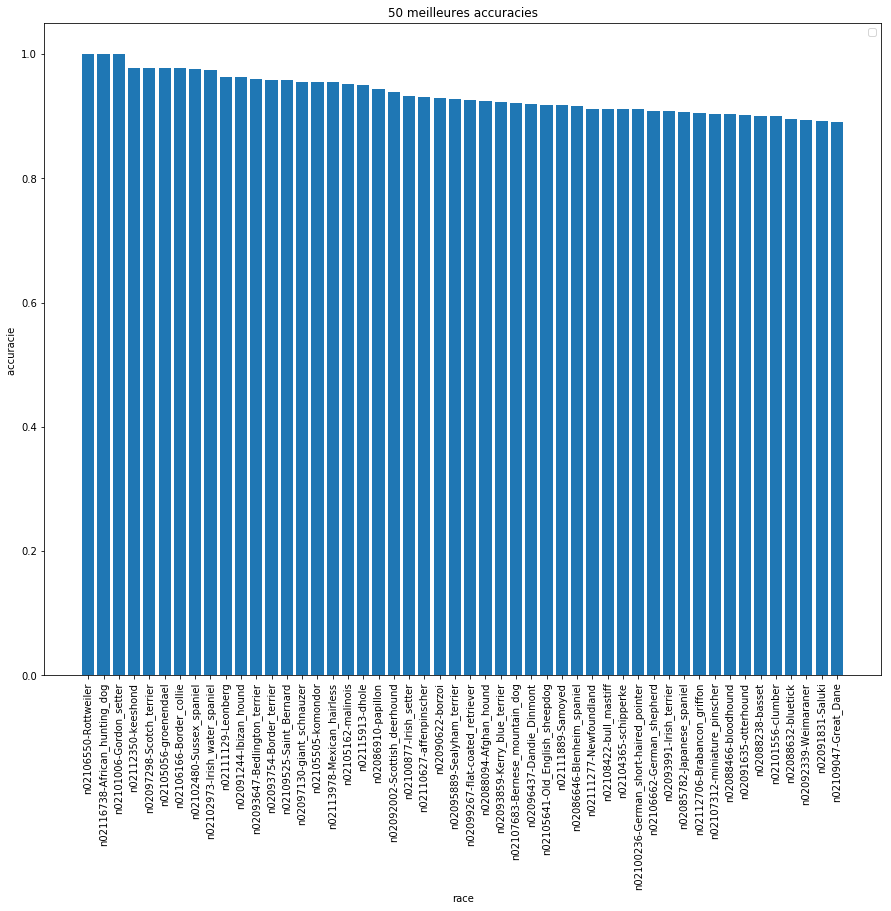

In [40]:
# afficher les performances pour les 50 races les mieux détectées

plt.figure(figsize=(15,12))
plt.title('50 meilleures accuracies')
plt.bar(df.iloc[0:50,0],df.iloc[0:50,1])
plt.legend(loc = 'accuracies')
        
plt.axis('tight')
plt.ylabel('accuracie ')
plt.xlabel('race')

plt.xticks(rotation=90)
plt.savefig('best_acc.png', dpi=400)
plt.show()  

No handles with labels found to put in legend.


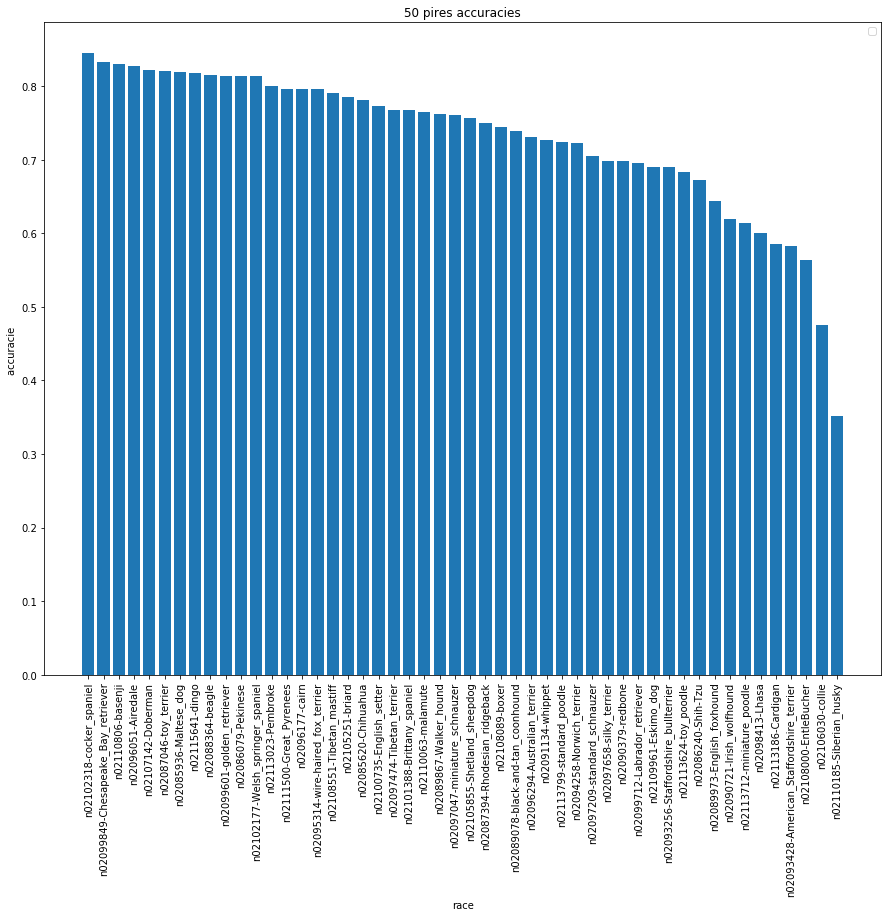

In [41]:
# afficher les 50 races les moins bien détectées

plt.figure(figsize=(15,12))
plt.title('50 pires accuracies')
plt.bar(df.iloc[70::,0],df.iloc[70::,1])
plt.legend(loc = 'accuracies')
        
plt.axis('tight')
plt.ylabel('accuracie ')
plt.xlabel('race')

plt.xticks(rotation=90)
plt.savefig('worst_acc_do.png', dpi=400)
plt.show()  

In [42]:
# afficher les performance pour les 30 couples de races avec les plus d'erreur de prédiction (faux positifs)
df2

,predict,test,fp
0,n02109961-Eskimo_dog,n02110185-Siberian_husky,0.407407
1,n02107908-Appenzeller,n02108000-EntleBucher,0.309091
2,n02106166-Border_collie,n02106030-collie,0.300000
3,n02113624-toy_poodle,n02113712-miniature_poodle,0.250000
4,n02092002-Scottish_deerhound,n02090721-Irish_wolfhound,0.238095
5,n02089867-Walker_hound,n02089973-English_foxhound,0.222222
6,n02094433-Yorkshire_terrier,n02097658-silky_terrier,0.207547
7,n02113023-Pembroke,n02113186-Cardigan,0.195122
8,n02113712-miniature_poodle,n02113624-toy_poodle,0.195122
9,n02098413-Lhasa,n02086240-Shih-Tzu,0.180328


# try xception

In [8]:
X_train = np.zeros((nb_train,dim_Xception,dim_Xception,3),dtype=np.float32)

y_train = np.zeros((nb_train,nb_classes),dtype='uint32')

In [9]:
X_test = np.zeros((nb_test,dim_Xception,dim_Xception,3),dtype=np.float32)

y_test = np.zeros((nb_test,nb_classes),dtype='uint32')

In [10]:
X_valid = np.zeros((nb_valid,dim_Xception,dim_Xception,3),dtype=np.float32)

y_valid = np.zeros((nb_valid,nb_classes),dtype='uint32')

In [11]:
j_te = 0

# Open a file
path = "./images_t/te/"
dirs = os.listdir( path )

for file in (dirs):
    #index = file.find('g')    
    
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_test[j_te,:] = label_binarize([class_name], classes=liste_name)
    #print (y_train[j_train,:])
        
    file_picture =  "./images_t/te/" + str(file)
    
    img = Image.open(file_picture)
    img.thumbnail((299, 299))
        
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
    X_test[j_te,0:matrix.shape[0],0:matrix.shape[1],:] = matrix[:,:,:]
        
    j_te = j_te + 1

In [12]:
j_valid = 0

# Open a file
path = "./images_t/valid/"
dirs = os.listdir( path )

for file in (dirs):
    #index = file.find('g')     
        
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_valid[j_valid,:] = label_binarize([class_name], classes=liste_name)
    #print (y_valid[j_valid,:])
        
    file_picture = "./images_t/valid/" + str(file)
     
    img = Image.open(file_picture)
    img.thumbnail((299, 299))
    
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
    X_valid[j_valid,0:matrix.shape[0],0:matrix.shape[1],:] = matrix[:,:,:]
        
    j_valid = j_valid + 1

In [13]:
j_train = 0

# Open a file
path = "./images_t/tr/"
dirs = os.listdir( path )

for file in (dirs):
    #index = file.find('g') 
    
        
    class_name = labels[labels['picture_name'] == str(file)].iloc[0,2]
    y_train[j_train,:] = label_binarize([class_name], classes=liste_name)
    #print (y_train[j_train,:])
        
    file_picture =  "./images_t/tr/" + str(file)
    
    img = Image.open(file_picture)
    img.thumbnail((299, 299))
        
    #img = load_img(file_picture, target_size=(224, 224))  # this is a PIL image 
    matrix = img_to_array(img)
    X_train[j_train,0:matrix.shape[0],0:matrix.shape[1],:] = matrix[:,:,:]
        
    j_train = j_train + 1

In [14]:
imput_train_Xception = preprocess_input_Xception(X_train)
train_Xception = Xception(weights='imagenet', include_top=False).predict(imput_train_Xception)

print ('done')

imput_test_Xception = preprocess_input_Xception(X_test.copy())
test_Xception = Xception(weights='imagenet', include_top=False).predict(imput_test_Xception)

print ('done')

imput_valid_Xception = preprocess_input_Xception(X_valid)
valid_Xception = Xception(weights='imagenet', include_top=False).predict(imput_valid_Xception)

done
done


In [15]:
def input_branch(input_shape=None):
    
    size = int(input_shape[2] / 4)
    
    branch_input = Input(shape=input_shape)
    branch = GlobalAveragePooling2D()(branch_input)
    branch = Dense(size, use_bias=False, kernel_initializer='uniform')(branch)
    branch = BatchNormalization()(branch)
    branch = Activation("relu")(branch)
    return branch, branch_input

Xception_branch, Xception_input = input_branch(input_shape=(10, 10, 2048))


net = Dropout(0.34)(Xception_branch)
net = Dense(1024, use_bias=False, kernel_initializer='uniform')(net)
net = BatchNormalization()(net)
net = Activation("relu")(net)
net = Dropout(0.34)(net)
net = Dense(120, kernel_initializer='uniform', activation="softmax")(net)

model = Model(inputs=[Xception_input], outputs=[net])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10, 10, 2048)      0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1048576   
_________________________________________________________________
batch_normalization_13 (Batc (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              524288    
__________

In [16]:
# checkpoints

early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "./models/{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=True)

In [17]:
model.compile(optimizer="rmsprop",
              loss='categorical_crossentropy',
              metrics=["accuracy"])
        
model.fit([train_Xception],y_train,
          validation_data=([valid_Xception ], y_valid),
          epochs=12, batch_size=4,callbacks=[model_checkpoint,early_stopping], verbose=2)

Train on 14855 samples, validate on 5827 samples
Epoch 1/12
 - 38s - loss: 1.3119 - acc: 0.6685 - val_loss: 0.5269 - val_acc: 0.8617
Epoch 2/12
 - 36s - loss: 0.9842 - acc: 0.7606 - val_loss: 0.4899 - val_acc: 0.8670
Epoch 3/12
 - 36s - loss: 0.9094 - acc: 0.7853 - val_loss: 0.4762 - val_acc: 0.8763
Epoch 4/12
 - 36s - loss: 0.9125 - acc: 0.7934 - val_loss: 0.4446 - val_acc: 0.8816
Epoch 5/12
 - 36s - loss: 0.8538 - acc: 0.8019 - val_loss: 0.4320 - val_acc: 0.8828
Epoch 6/12
 - 36s - loss: 0.8179 - acc: 0.8092 - val_loss: 0.4131 - val_acc: 0.8840
Epoch 7/12
 - 35s - loss: 0.7844 - acc: 0.8076 - val_loss: 0.4134 - val_acc: 0.8857
Epoch 8/12
 - 36s - loss: 0.7395 - acc: 0.8171 - val_loss: 0.3992 - val_acc: 0.8842
Epoch 9/12
 - 36s - loss: 0.7314 - acc: 0.8174 - val_loss: 0.3858 - val_acc: 0.8902
Epoch 10/12
 - 36s - loss: 0.7042 - acc: 0.8208 - val_loss: 0.3883 - val_acc: 0.8895
Epoch 11/12
 - 36s - loss: 0.7150 - acc: 0.8244 - val_loss: 0.3758 - val_acc: 0.8936
Epoch 12/12
 - 36s - loss

In [18]:
predictions = model.predict([test_Xception])
breed_predictions = [np.argmax(prediction) for prediction in predictions]
breed_true_labels = [np.argmax(true_label) for true_label in y_test]
print('Test accuracy: %.4f%%' % (accuracy_score(breed_true_labels, breed_predictions) * 100))

Test accuracy: 88.1773%


In [19]:

list_predict = []
list_test = []

for i in range (len(breed_predictions)):
    list_predict.append(np.argmax(predictions[i]))
    list_test.append(np.argmax(y_test[i,:]))
    

d = {'predict': list_predict, 'test': list_test}
df = pd.DataFrame(data=d)

valeurs = plot_value_counts('test',df=df)
print (valeurs.shape)
print (nb_classes)


heat_matrix = np.zeros((nb_classes,nb_classes))

valeurs['test'] = valeurs['test'].astype('float64')

valeurs = valeurs.sort_values(by=['test'])



for i in range (valeurs.shape[0]):
    for j in range (valeurs.shape[0]):
        
        heat_matrix[i,j] = df[(df.iloc[:,0] == float(valeurs.iloc[i,0])) & (df.iloc[:,1] == float(valeurs.iloc[j,0]))].shape[0] / float(valeurs.iloc[j,1])
       
        

(120, 3)
120


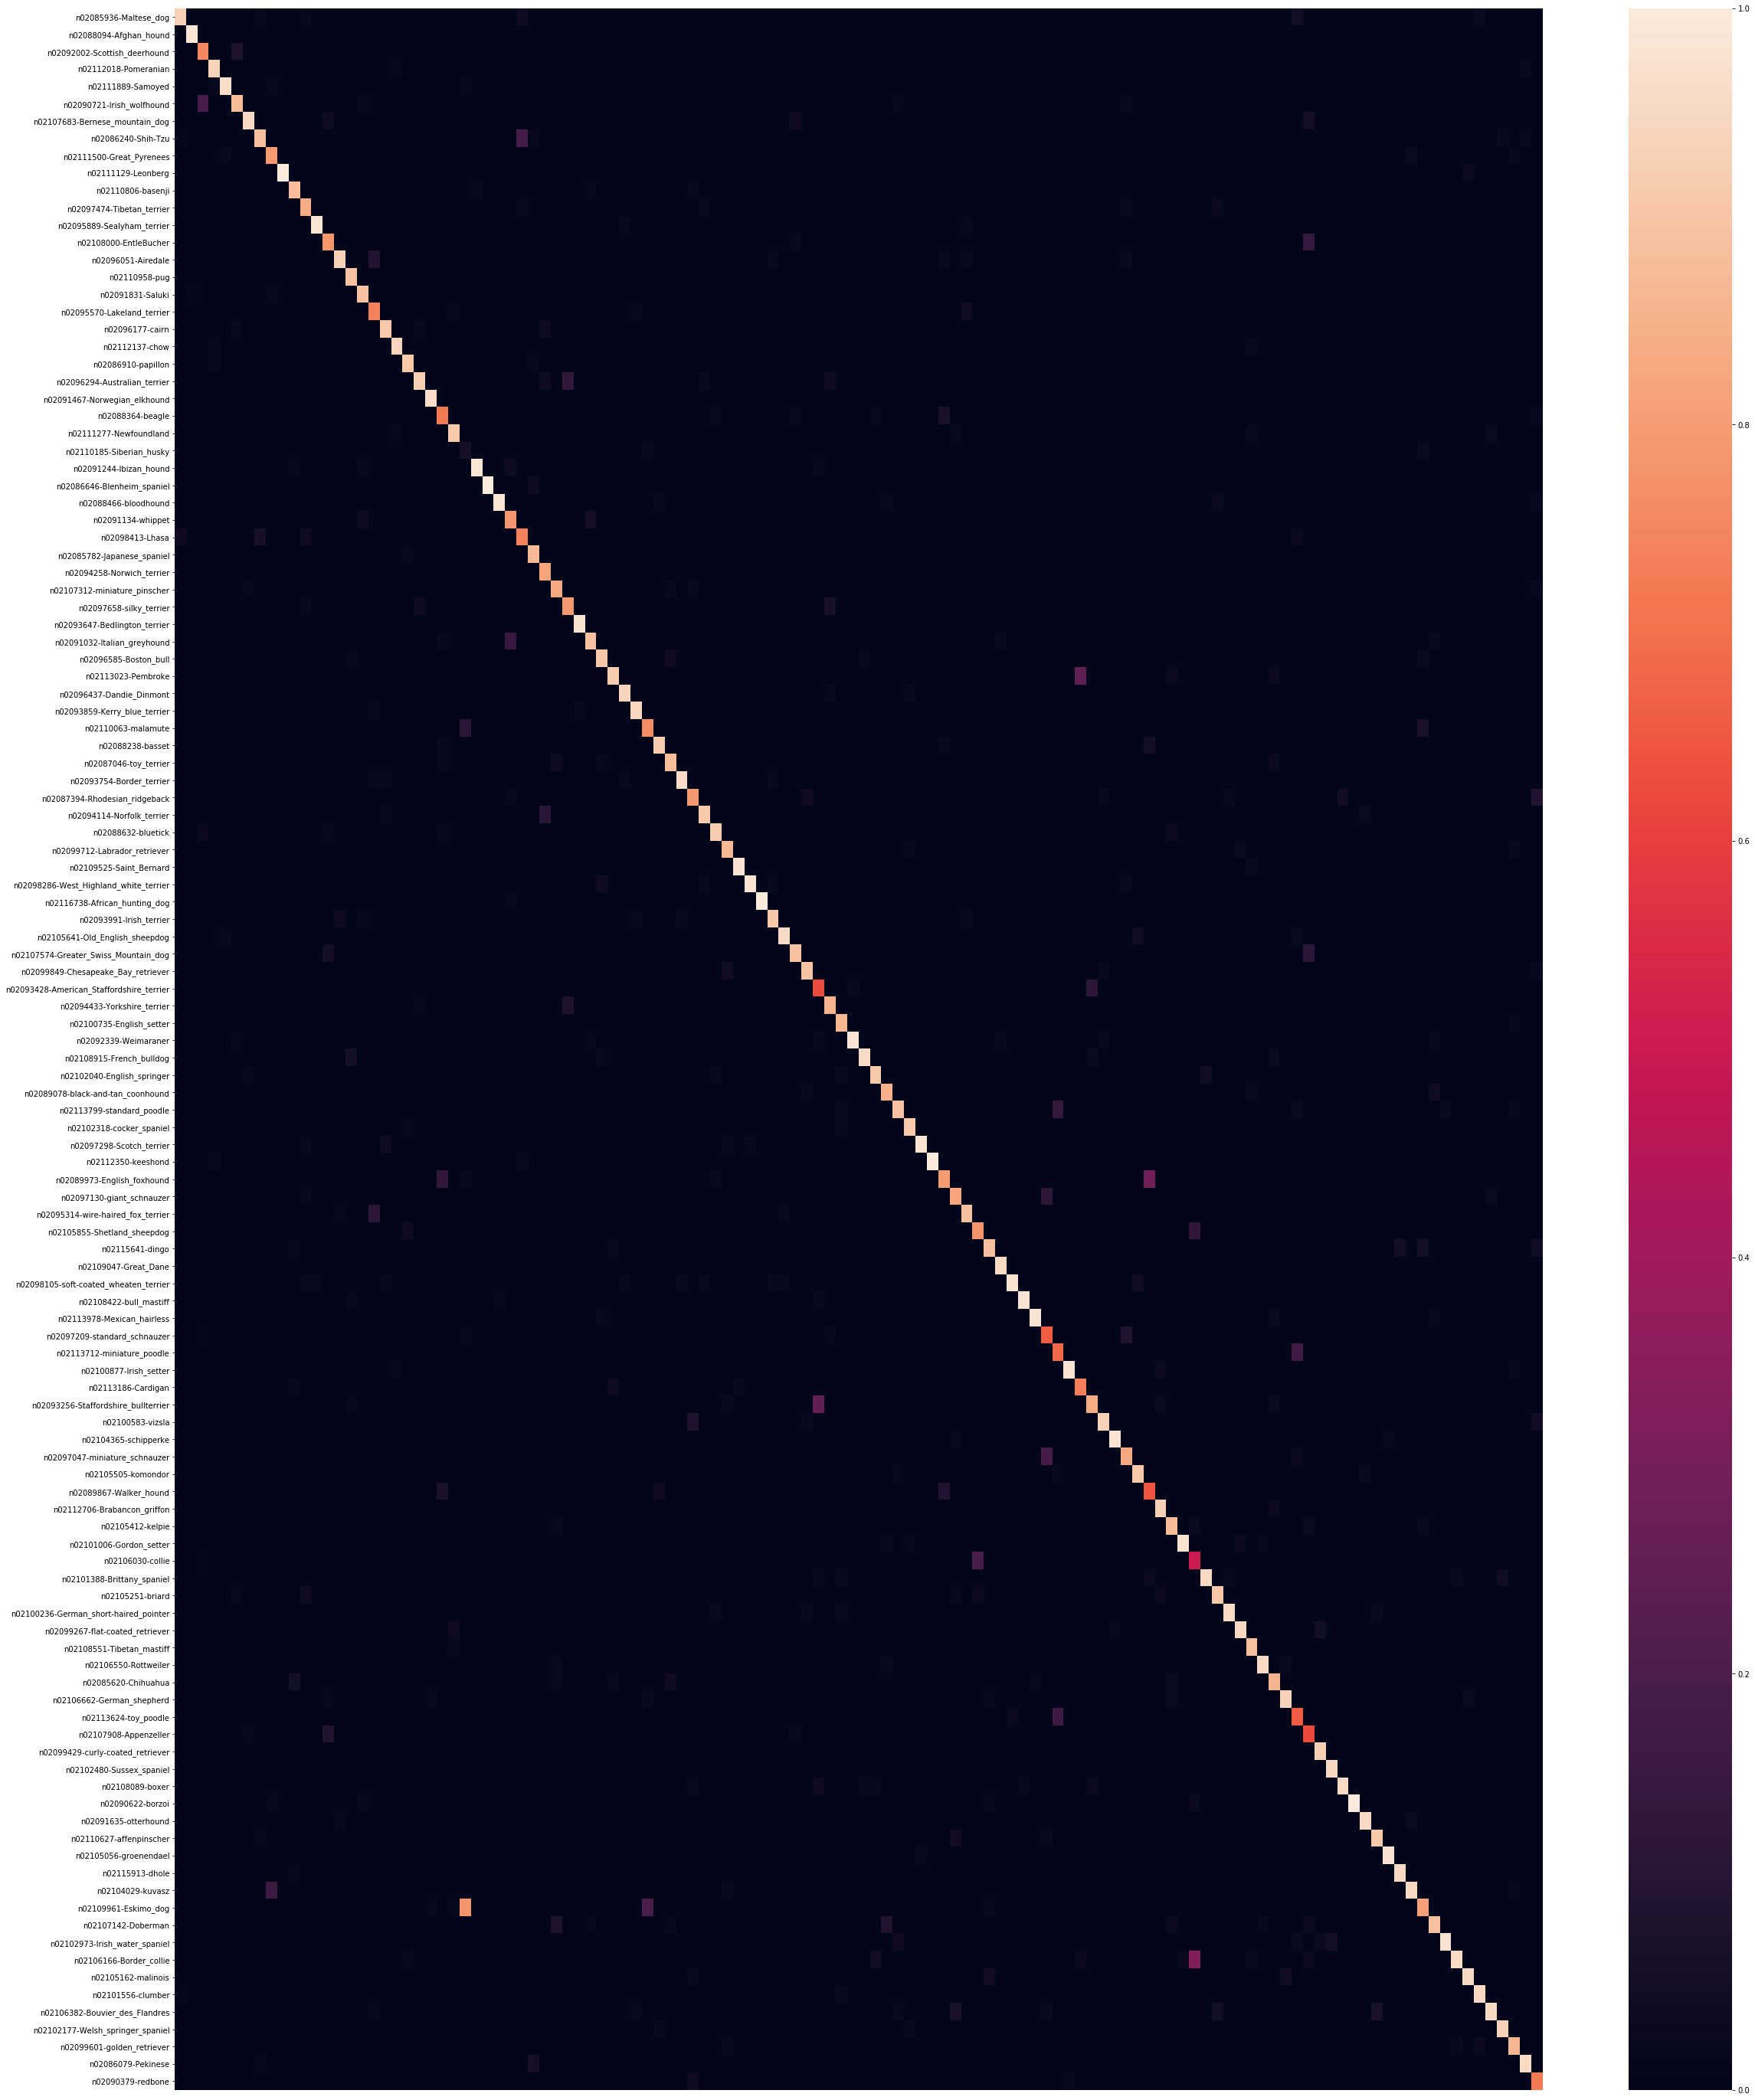

In [20]:
plt.figure(figsize=(40,50))

ax = sns.heatmap(heat_matrix,yticklabels=liste_name)

ax.axes.get_xaxis().set_visible(False)

plt.savefig('heatmdap_3XCEP.png')

In [21]:
def visualiser(df,nb_exemples):
    #""" visualiser les échecs """"
    
    # mixed data do not print every time the same pictures    
    df = shuffle(df)

    # i breack
    i_b = 0

    # nombre d'exemples que l'on cherche à visualiser

    fig = plt.figure(1, figsize=(16, 16))

    grid = ImageGrid(fig, 111, nrows_ncols=(nb_exemples, 2), axes_pad=0.1)

    
    for i in range (df.shape[0]):
        if (df.iloc[i,0] != df.iloc[i,1]):         
                
            ax = grid[i_b]

            indice = int(df.iloc[2*i,0])

            ax.imshow(X_test[2*i,:,:,:] / 255.)
            ax.text(20, 100, 'PREDICTED: {}'.format(liste_name[indice]), color='white', backgroundcolor='b', alpha=1)

            ax.axis('off')
                
            i_b = i_b + 1
                
                
            ax = grid[i_b]    

            indice = int(df.iloc[2*i+1,0])

            ax.imshow(X_test[2*i+1,:,:,:] / 255.)
            ax.text(20, 100, 'REAL: {}'.format(liste_name[indice]), color='white', backgroundcolor='r', alpha=1)

            ax.axis('off')       


            i_b = i_b + 1
            
            if i_b > nb_exemples + 2:
            
                break  # otherwise the generator would loop indefinitely

    ax.axis('off')            
    plt.show()      
        

In [22]:
def performance_best(liste_name,heatmap,nb):
    """retourne la liste des nb meilleures performances (race/race) ainsi que la liste des accuracies"""
    perf_name = []
    perf_element = []    
    
    for i in range (heatmap.shape[0]):
        
        perf_element.append(heatmap[i,i])
        perf_name.append(liste_name[i])
        
    d = {'name': perf_name[:], 'acc': perf_element[:]}
    df = pd.DataFrame(data=d)
    
    df = df.sort_values(by=['acc'], ascending=[False])
    
    a = heatmap.copy()
    for i in range (heatmap.shape[0]):
        
        # on ne tient pas compte des éléments sur la diagonale
        a[i,i] = 0
        
    liste_predict, liste_test, value = [], [], []
    for i in range (nb):        
               
        z = (np.argmax(a) + 1) / a.shape[0]
        #print (z)

        if ((np.argmax(a)+1)%(a.shape[0]) == 0):

            ordd = int(z) - 1
            abss = a.shape[0] - 1

        else : 

            ordd = int(z)
            abss = (np.argmax(a)+1)%(a.shape[0]) - 1 
            
        liste_predict.append(liste_name[ordd])        
        liste_test.append(liste_name[abss])
        
        value.append(a[ordd,abss])
            
        a[ordd,abss] = 0 
        
    d = {'predict': liste_predict[:], 'test': liste_test[:], 'fp':value[:]}
    df2 = pd.DataFrame(data=d) 
    
    df2 = df2.sort_values(by=['fp'], ascending=[False])
    
    
    return (df,df2)
        

In [23]:
df, df2 = performance_best(liste_name=liste_name[:],heatmap=heat_matrix[:,:],nb=30)[:]

No handles with labels found to put in legend.
/usr/local/lib/python3.6/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "accuracies". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


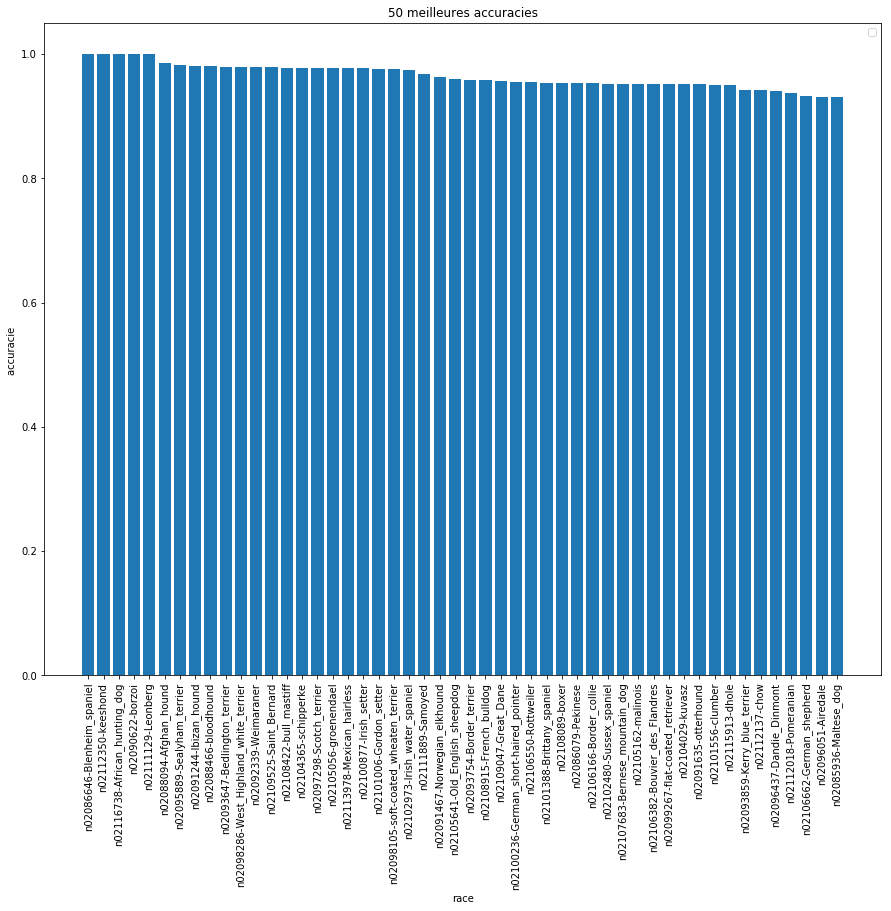

In [24]:
# afficher les performances pour les 50 races les mieux détectées

plt.figure(figsize=(15,12))
plt.title('50 meilleures accuracies')
plt.bar(df.iloc[0:50,0],df.iloc[0:50,1])
plt.legend(loc = 'accuracies')
        
plt.axis('tight')
plt.ylabel('accuracie ')
plt.xlabel('race')

plt.xticks(rotation=90)
plt.savefig('best_ajcc.png', dpi=400)
plt.show()  

No handles with labels found to put in legend.


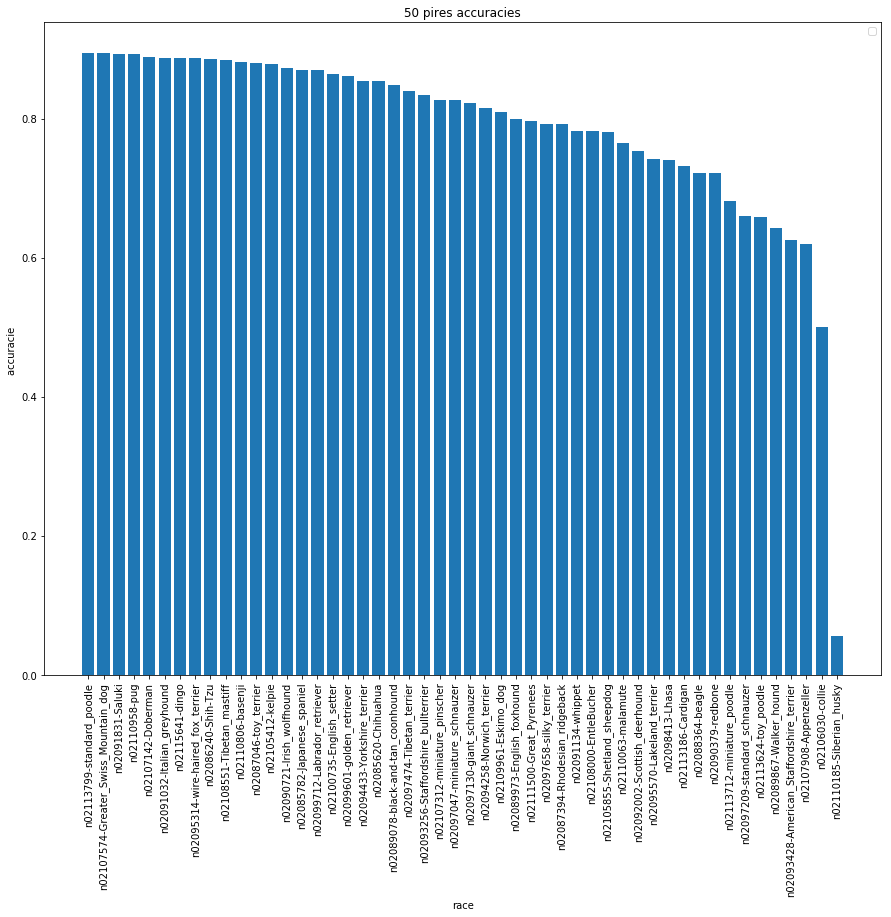

In [25]:
# afficher les 50 races les moins bien détectées

plt.figure(figsize=(15,12))
plt.title('50 pires accuracies')
plt.bar(df.iloc[70::,0],df.iloc[70::,1])
plt.legend(loc = 'accuracies')
        
plt.axis('tight')
plt.ylabel('accuracie ')
plt.xlabel('race')

plt.xticks(rotation=90)
plt.savefig('worst_acfc_do.png', dpi=400)
plt.show()  

In [26]:
# afficher les performance pour les 30 couples de races avec les plus d'erreur de prédiction (faux positifs)
df2

,predict,test,fp
0,n02109961-Eskimo_dog,n02110185-Siberian_husky,0.777778
1,n02106166-Border_collie,n02106030-collie,0.325000
2,n02089973-English_foxhound,n02089867-Walker_hound,0.285714
3,n02093256-Staffordshire_bullterrier,n02093428-American_Staffordshire_terrier,0.250000
4,n02113023-Pembroke,n02113186-Cardigan,0.243902
5,n02109961-Eskimo_dog,n02110063-malamute,0.196078
6,n02106030-collie,n02105855-Shetland_sheepdog,0.195122
7,n02090721-Irish_wolfhound,n02092002-Scottish_deerhound,0.184615
8,n02097047-miniature_schnauzer,n02097209-standard_schnauzer,0.181818
9,n02086240-Shih-Tzu,n02098413-Lhasa,0.180000
